# Bayesian Linear Mixed-Effects Regression
## Computational Methods in Psychology (and Neuroscience)
### Psychology 4500/7559 --- Fall 2020
By: Per B. Sederberg, PhD



# Course Evaluations

- Please fill our your ***anonymous*** course evaluations, including custom comments if you can. 
- I really do pay attention to your feedback and will use your suggestions to improve the course.
- It's good to hear both aspects of the class you liked and thought worked well, as well as those you disliked and think should change (perhaps even with a suggestion for *how* they should change!)

### Thank you!!!


# A reminder about grading

The class is graded out of a total of 100 points, translated to the standard grading scale:

- Lesson exercises / class participation (30 pts)
  - There have been 16 points worth of exercises
  - Everyone will receive 15 free points for class participation
  - So you'll have one point to help you make up something you missed
- List generation project (20 pts)
- Experiment project (20 pts)
- Data Analysis project (30 pts)
  - See next slide...

# Final Project

The final project is a synthesis of the experiment development, data analysis, and visualization we've covered in class. The goal is to perform an analysis on one of the experiments from the class, producing a notebook with part of what would end up in an actual manuscript submission.

Your notebook will include:

- Methods
  - A write-up of the task design and methods for data collection
- Results
  - Plots and statistics organized by the question you are asking
  - A short discussion of each plot/statistic stating what you found

We will provide a full description of the final project as a separate notebook, outlining each of these pieces in detail.

Also, even though we don't have class, we will be continuing office hours (except for the Wednesday before Thanksgiving), so feel free to come chat with us or set up a time to meet via Slack.

***Due Date: By 11:59 pm on Tuesday, Dec. 8th, which is the day our final would be scheduled.***

# Lesson Objectives

Upon completion of this lesson, students should have learned:

1. Quick ANOVA example
2. Introduction to mixed-effects models
3. Introduction to Bayesian models
4. Fit and visualize a Bayesian mixed-effects regression to our data


# New library to install

You're going to need new Bayesian modeling and plotting libraries, so run these lines at your Anaconda Prompt/Terminal:

```bash
conda install -c conda-forge arviz
conda install patsy pymc3 pystan
pip install bambi
```


In [1]:
# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
import plotnine as pn
import scipy.stats.distributions as dists     # probability distributions
from scipy import stats
from glob import glob
import os
import arviz as az
import bambi as bmb
import statsmodels.formula.api as smf
import statsmodels.api as sm

from smile.log import log2dl

from ci_within import ci_within

## Custom SLOG loading function

In [2]:
# custom function to load slogs
def load_all_subj_logs(task_dir, log_file):
    # load in a list of all the subj
    subjs = [os.path.split(subj_dir)[-1] 
             for subj_dir in glob(os.path.join(task_dir, 's*'))]
    subjs.sort()

    # loop over subj and their data
    all_dat = []
    for subj in subjs:
        # set the file
        log_path = os.path.join(task_dir, subj, log_file)
        #print(log_path)

        # load the data
        all_dat.extend(log2dl(log_path, subj=subj))

    df = pd.DataFrame(all_dat)
    
    return df

## Load in all the data

In [3]:
# load the data from each task
task_dir = os.path.join('data', 'Taskapalooza')

df_f = load_all_subj_logs(task_dir, 'log_flanker')
df_i = load_all_subj_logs(task_dir, 'log_image_test')
df_w = load_all_subj_logs(task_dir, 'log_word_test')
df_i.head()

,resp_map_lure,resp_map_target,block_num,trial_num,stim_on_time,stim_on_error,resp,resp_time_time,resp_time_error,rt,correct,log_time,filename,in_out,novelty,cond,subj,log_num
0,F,J,0,0,2361.470167,0.0,F,2362.502265,0.000391,1.032098,True,2363.385215,out2646.jpg,outdoor,lure,outdoor,s001,0
1,F,J,0,1,2363.392059,0.0,J,2363.993073,0.001033,0.601014,True,2364.559602,out0031_new.jpg,outdoor,target,outdoor,s001,0
2,F,J,0,2,2364.572868,0.0,F,2365.363671,0.000197,0.790803,True,2365.870152,out1227.jpg,outdoor,lure,outdoor,s001,0
3,F,J,0,3,2365.874493,0.0,F,2366.714544,0.000191,0.840051,True,2367.588254,out0134_new.jpg,outdoor,lure,outdoor,s001,0
4,F,J,0,4,2367.592558,0.0,F,2368.463209,0.000248,0.870651,True,2369.152451,out2086.jpg,outdoor,lure,outdoor,s001,0


## Some data clean-up

In [4]:
# it turns out the cond is easier to visualize as pure and mixed
def fix_conds(df, type_col):
    # loop over the unique subjects
    usubj = df.subj.unique()
    for s in usubj:
        # loop over their blocks
        ublocks = df.loc[df['subj']==s, 'block_num'].unique()
        for b in ublocks:
            # grab the data for that subj and block
            dfb = df.loc[(df['subj']==s)&(df['block_num']==b)]
            
            # get the unique types in that block
            uval = dfb[type_col].unique()
            if len(uval) > 1:
                # it's mixed
                df.loc[(df['subj']==s)&(df.block_num==b), 'cond'] = 'mixed'
            else:
                # it's the pure
                df.loc[(df['subj']==s)&(df.block_num==b), 'cond'] = 'pure'

# fix the conds in the recog experiments (updated in place)
fix_conds(df_i, type_col='in_out')
fix_conds(df_w, type_col='valence')

# add in log_rt columns
df_f['log_rt'] = np.log(df_f['rt'])
df_i['log_rt'] = np.log(df_i['rt'])
df_w['log_rt'] = np.log(df_w['rt'])

# must make correct an int
df_f['correct'] = df_f['correct'].astype(np.int)
df_i['correct'] = df_i['correct'].astype(np.int)
df_w['correct'] = df_w['correct'].astype(np.int)

# add in a column for whether they made an 'old' response
df_i['old_resp'] = (df_i['resp_map_target'] == df_i['resp']).astype(np.int)
df_w['old_resp'] = (df_w['resp_map_target'] == df_w['resp']).astype(np.int)

# process some of the valence info
df_w['valence_mean'] = df_w['valence_mean'].astype(np.float)
df_w['arousal_mean'] = df_w['arousal_mean'].astype(np.float)
df_w['dominance_mean'] = df_w['dominance_mean'].astype(np.float)
df_w['abs_valence'] = np.abs(df_w['valence_mean'] - 5.0)
df_w['abs_arousal'] = np.abs(df_w['arousal_mean'] - 5.0)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


# Word Recognition

Primary question: Is there an effect of valence (potentially interacting with condition) on recognition accuracy?

In [5]:
# get the error corrected by condition and whether they answered correctly
res = ci_within(df_w,  
                indexvar='subj',       # column that identifies a subject
                withinvars=['cond', 'novelty', 'valence'],     # list of columns for grouping within subject
                measvar='correct')        # dependent variable averaging over
res = res.reset_index()
res

,cond,novelty,valence,mean,std,sem,ci,len
0,mixed,lure,neg,0.883152,0.336097,0.012389,0.024321,736.0
1,mixed,lure,neu,0.902174,0.303774,0.011197,0.021982,736.0
2,mixed,lure,pos,0.879076,0.331184,0.012208,0.023966,736.0
3,mixed,target,neg,0.782609,0.420988,0.015518,0.030465,736.0
4,mixed,target,neu,0.771739,0.429193,0.015820,0.031058,736.0
5,mixed,target,pos,0.729620,0.459092,0.016922,0.033222,736.0
6,pure,lure,neg,0.865942,0.346120,0.010417,0.020439,1104.0
7,pure,lure,neu,0.874094,0.331526,0.009978,0.019578,1104.0
8,pure,lure,pos,0.864130,0.344118,0.010357,0.020321,1104.0
9,pure,target,neg,0.794384,0.411845,0.012395,0.024321,1104.0


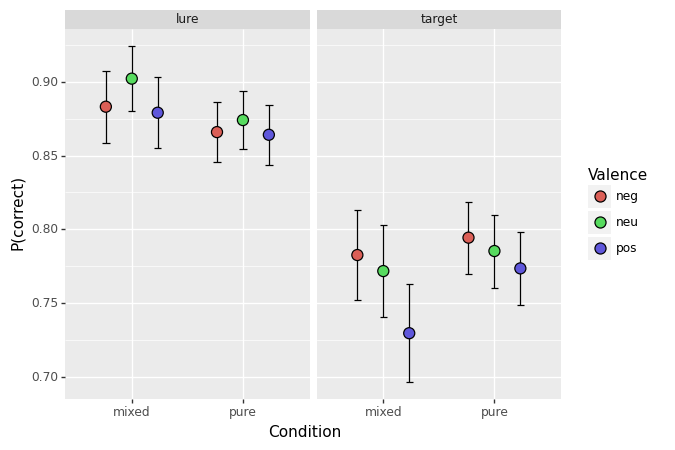

<ggplot: (132820405604)>

In [6]:
p = (pn.ggplot(res, pn.aes('cond', 'mean', fill='valence'))
     + pn.geom_errorbar(pn.aes(ymin='mean-ci', ymax='mean+ci', width=0.2), 
                        position=pn.position_dodge(.7))
     + pn.geom_point(position=pn.position_dodge(.7), size=4)
     + pn.facet_wrap('~novelty')
     + pn.labs(x="Condition", y = "P(correct)", fill='Valence')
    )
p

## Testing for significance

Using a standard linear model, we must average performance within subject


In [7]:
# use the agg method to get the means
perf = df_w.groupby(['subj', 'cond', 'valence', 'novelty'])['correct'].mean()
perf = perf.reset_index()
perf

,subj,cond,valence,novelty,correct
0,s001,mixed,neg,lure,0.937500
1,s001,mixed,neg,target,0.812500
2,s001,mixed,neu,lure,0.906250
3,s001,mixed,neu,target,0.875000
4,s001,mixed,pos,lure,0.968750
...,...,...,...,...,...
271,s023,pure,neg,target,0.625000
272,s023,pure,neu,lure,0.687500
273,s023,pure,neu,target,0.791667
274,s023,pure,pos,lure,0.895833


In [8]:
# build a linear regression of the full model
m0 = smf.ols("correct ~ cond * valence * novelty", perf).fit()
m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                correct   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     4.738
Date:                Mon, 07 Dec 2020   Prob (F-statistic):           1.23e-06
Time:                        21:22:03   Log-Likelihood:                 183.23
No. Observations:                 276   AIC:                            -342.5
Df Residuals:                     264   BIC:                            -299.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                         0.8832      0.027     33.251      0.000       0.831       0.935
cond[T.pure]                                     -0.0172      0.038     -0.458      0.647      -0.091       0.057
valence[T.neu]                                    0.0190      0.038      0.506      0.613      -0.055       0.093
valence[T.pos]                                   -0.0041      0.038     -0.109      0.914      -0.078       0.070
novelty[T.target]                                -0.1005      0.038     -2.677      0.008      -0.175      -0.027
cond[T.pure]:valence[T.neu]                      -0.0109      0.053     -0.205      0.838      -0.115       0.094
cond[T.pure]:valence[T.pos]                       0.0023      0.053      0.043      0.966      -0.102       0.107
cond[T.pure]:novelty[T.target]                    0.0290      0.053      0.546      0.586      -0.076       0.134
valence[T.neu]:novelty[T.target]                 -0.0299      0.053     -0.563      0.574      -0.134       0.075
valence[T.pos]:novelty[T.target]                 -0.0489      0.053     -0.921      0.358      -0.154       0.056
cond[T.pure]:valence[T.neu]:novelty[T.target]     0.0127      0.075      0.169      0.866      -0.135       0.161
cond[T.pure]:valence[T.pos]:novelty[T.target]     0.0299      0.075      0.398      0.691      -0.118       0.178
==============================================================================
Omnibus:                       29.804   Durbin-Watson:                   1.533
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.051
Skew:                          -0.843   Prob(JB):                     1.48e-08
Kurtosis:                       3.542   Cond. No.                         25.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Running an ANOVA on the linear model results

- Such a complicated linear model is really hard to unpack
- The most common approach to modeling the data would be a repeated measures ANOVA
- Luckily, a linear regress is really just an ANOVA if you make the right comparisons
- Statsmodels provides a way to handle that for you.

In [9]:
# Run a type-II repeated measures ANOVA based on the linear model results
sm.stats.anova_lm(m0, typ=2)

,sum_sq,df,F,PR(>F)
cond,0.000157,1.0,0.009692,9.216506e-01
valence,0.026771,2.0,0.824999,4.393621e-01
novelty,0.763966,1.0,47.085507,4.826049e-11
cond:valence,0.006051,2.0,0.186478,8.299863e-01
cond:novelty,0.032157,1.0,1.981955,1.603610e-01
valence:novelty,0.013930,2.0,0.429267,6.514397e-01
cond:valence:novelty,0.002588,2.0,0.079767,9.233540e-01
Residual,4.283420,264.0,NaN,NaN


- Looks like a big effect of novelty (target vs. lure), but not much else.
- This isn't a huge surprise from that graph

## So what's the problem?

- If you average data within subject, what happened to the within-subject variability in performance?
  - It's gone!
- It could be that the entire effect is driven by item outliers (see Clark, 1993)

## An item effect

* Some average subject data

| Subject | Cond 1 | Cond 2 |
| :- | -: | -: |
| Pat | 400ms | 500ms
| Sam  | 420ms | 530ms
| Robin | 380ms | 490ms


* Some average item data

| Item | Cond 1 | Cond 2 |
| :- | -: | -: |
| chicken | 390ms  | 395ms |
| octopus | 410ms  | **1100ms** |
| horse |   380ms  | 400ms |


* The effect is driven by a single item, "octopus"!

* This is why it's now common practice to include both subject and
  item analyses.


## Subjects and Items

- What if you could account for subject and item-level variability
  *at the same time*?

- Mixed effects models allow just that, and you get all that and more!
  You can include:

  - Continuous dependent and independent variables.

  - Interactions between any combo of continuous and discrete
    variables.


- This means we can analyze the actual valence values instead of the groups!
- You are also working with the raw data instead of summary statistics!

## Mixed Effects

* Split your model into **random** and **fixed** effects.

* For **random** effects we expect random variation across that
  variable (e.g., subjects, items, etc...)

* For **fixed** effects you expect systematic changes between
  conditions (i.e. your experimental manipulations).


# Bayesian models

- As mentioned last class, it is possible to build models of the world out of probability distributions.
- The process involves:
  - Determining the correct probability distribution function for your observed data
  - Then finding the parameters of that function to maximize the probability of observing your data

## Visualizing the fitting process

Say we have some data, can we figure out what model and parameters could have generated those data?

In [10]:
data = np.array([3.39317851, 0.92986704, 2.6072234 , 1.63686968, 2.69860129,
                 2.3531901 , 2.67225635, 1.93437793, 2.0751784 , 3.71950222,
                 1.39434613, 2.37011522, 0.81351156, 2.36217543, 3.30390727,
                 2.78832169, 2.11905216, 1.48325417, 0.73556411, 2.36148697])

<ipython-input-11-8bf58977976c>:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


Text(0.5, 1.0, 'Log Likelihood: -24.298')

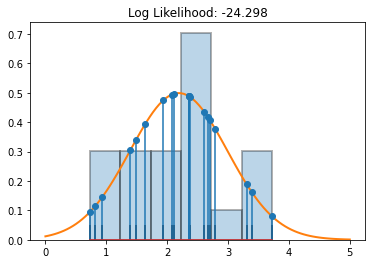

In [11]:
# let's start by visulizing our data
plt.hist(data, bins='auto', alpha=.3, lw=2, edgecolor='k', density=True);
plt.vlines(data, ymin=0, ymax=0.05)

# adjust the mean (mu) and standard deviation (sigma) to maximize the log likelihood
mu = 2.19
sigma = 0.8
xvals = np.linspace(0, 5, 100)
d = dists.norm(loc=mu, scale=sigma)
plt.plot(xvals, d.pdf(xvals), lw=2)
plt.stem(data, d.pdf(data))
plt.title('Log Likelihood: %.3f' % np.log(d.pdf(data)).sum())

## Maximum Likelihood

We can calculate parameters that maximize the likelihood of observing the data given the model and those parameters:

$$\hat{L} = P(D \mid \hat{\theta}, M)$$

However, this approach ignores the fact that there are many parameter values that *could* have generated the same data.


## Bayesian Inference

Instead, what we'd really like to know is the full set of possible parameters given the data:

$$P(\theta \mid D)$$

This should look familiar and a probability reminder should give a hint for how to calculate it...

## Basics of Probability



### A   
$P(A) \in [0, 1]$

### not A
$1 - P(A)$

### A or B 
$P(A \cup B) = P(A) + P(B) - P(A \cap B)$ or <br> $P(A \cup B) = P(A) + P(B)$ if A and B are mutually exclusive

### A and B
$P(A \cap B) = P(A \mid B) P(B) = P(B \mid A) P(A)$ or <br> $P(A \cap B) = P(A) P(B)$ if A and B are independent

### A given B 
$P(A \mid B) = \frac{P(A \cap B)}{P(B)} = \frac{P(B \mid A) P(A)}{P(B)}$






## Bayes Rule

$$P(\theta \mid D) = \frac{P(\theta \cap D)}{P(D)} = \frac{P(D \mid \theta) P(\theta)}{P(D)} \propto P(D \mid \theta) P(\theta)$$

- $P(\theta \mid D)$ is the posterior probability AKA the likelihood of observing each of the probability values given the data. Initial belief of what the data is based on prior experience and prior knowledge
- $P(D \mid \theta)$ is the likelihood AKA the probability of observing the data given any set of data
- $P(\theta)$ is the prior probability AKA the probabilty of observing any of the specific data values (weird to see 10 second reaction time)
  - Theory of memory relying on past experiences. Can always be updated.
- $P(D)$ is the marginal likelihood (*does not depend on model or params*) AKA the probability of just observing the data being seen at all, independent of the model (the most impossible to quantify)

## What's a prior?

A prior probability represents the initial belief in the potential values of some quantity before any new evidence is taken into account.

The notion of a prior is one of the key differences between Bayesian and Frequentist approaches. Bayesians believe that we should take such prior knowledge into account when making decisions and that this prior knowledge can be updated with each new bit of evidence:

"Today's posterior is tomorrow's prior"

That said, priors are also a major critique of Bayesian approaches because they can have a massive effect on the posterior (i.e., the conclusions you draw).

## Bayesian Inference

Determining $P(\theta \mid D)$ can be difficult for a number of reasons:

- The likelihood $P(D \mid \theta)$ is often intractable, requiring simulation
- Can be unfeasible/impossible to determine the marginal likelihood ($P(D)$)

The standard approach is to use Markov chain Monte Carlo (MCMC) to estimate the posterior.


# Bayesian Mixed-effects Regression

- We can use hierarchical Bayesian approaches to build regression models that predict trial-level data taking   into account both subject-level and item-level variability.

- The *BAyesian Model-Building Interface ([Bambi](https://bambinos.github.io/bambi/index.html))* package helps us build and perform parameter inference on mixed-effects models.


## Treating valence as continuous

C:\ProgramData\Anaconda3\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 22'. Pick better value with 'binwidth'.


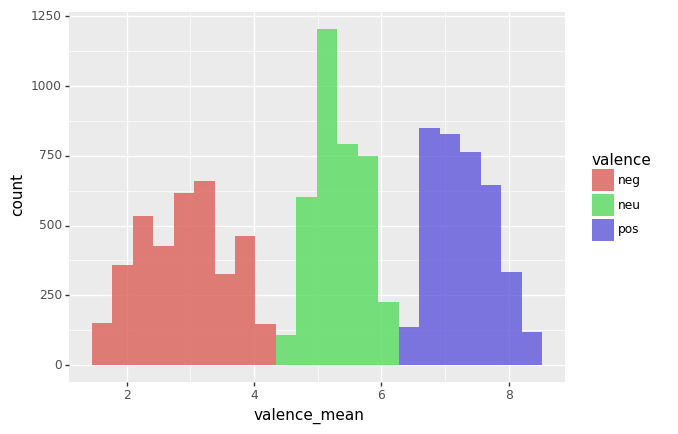

<ggplot: (132823671218)>

In [12]:

# Show the distributions of valence values
p = (pn.ggplot(df_w, pn.aes('valence_mean', fill='valence'))
     + pn.geom_histogram(alpha=.8)
    )
p

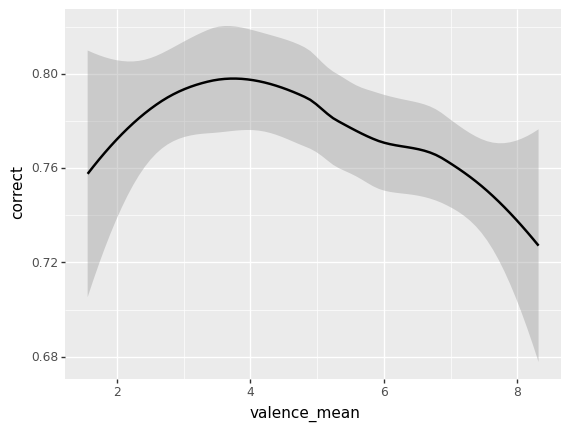

<ggplot: (132823671107)>

In [13]:
p = (pn.ggplot(df_w.loc[df_w['novelty']=='target'], pn.aes('valence_mean', 'correct'))
     + pn.geom_smooth(method='loess')
    )
p

## Build and fit the model

In [14]:
# First initialize the model with the data frame we're using
model = bmb.Model(df_w.loc[df_w['novelty']=='target'])

# next build the regression with both fixed and random effects
results = model.fit('correct ~ cond * valence_mean', 
                    random=['1|subj', '1|description'], 
                    family='bernoulli')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\bambi\models.py:267: UserWarning: Modeling the probability that correct=='1'
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|description_offset, 1|description_sd, 1|subj_offset, 1|subj_sd, cond:valence_mean, valence_mean, cond, Intercept]
INFO:pymc3:NUTS: [1|description_offset, 1|description_sd, 1|subj_offset, 1|subj_sd, cond:valence_mean, valence_mean, cond, Inter

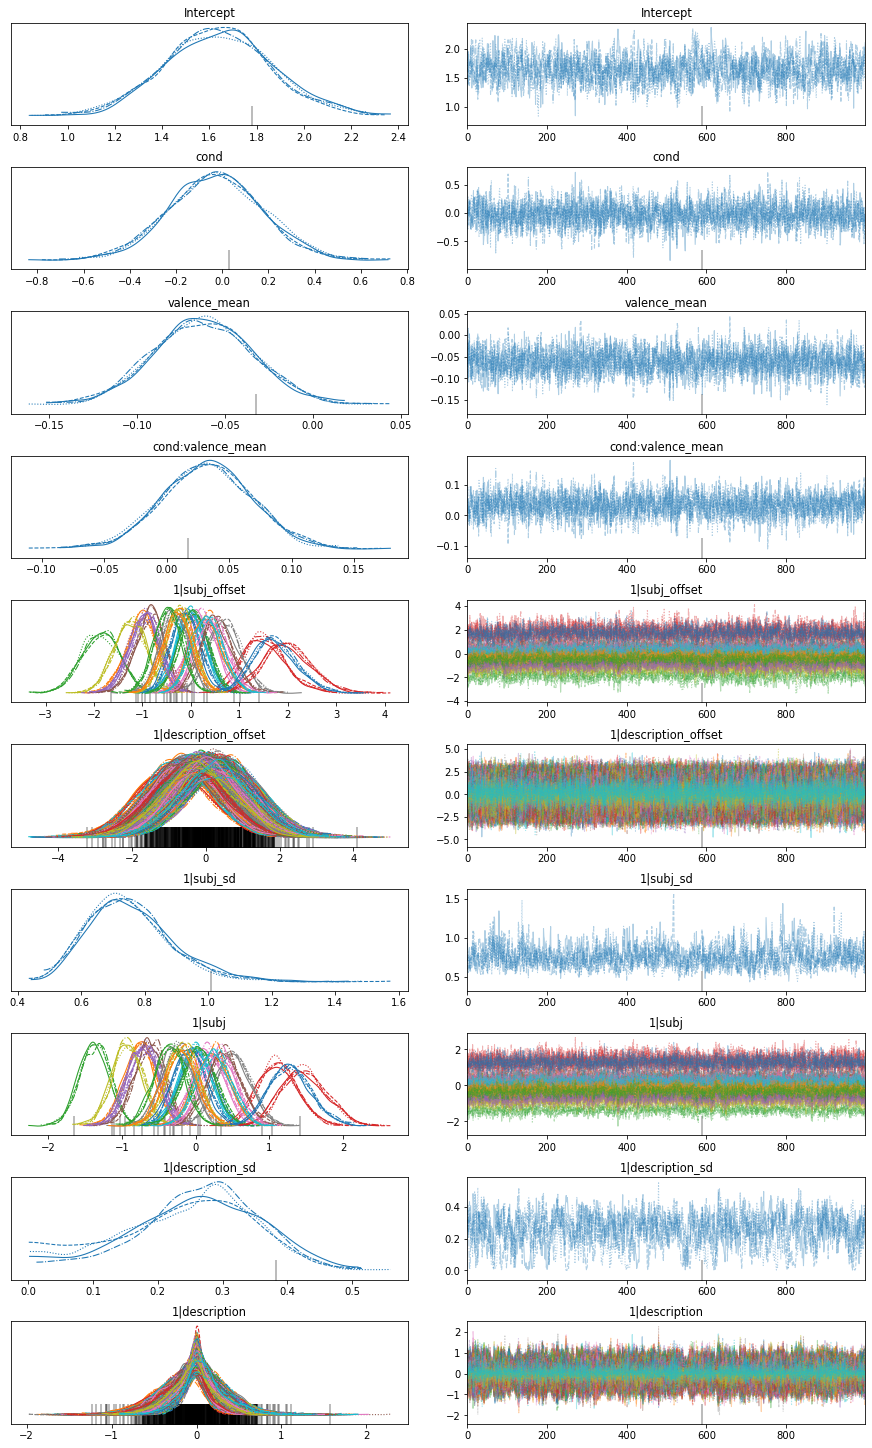

In [17]:
# plot the inference traces for the fit
az.plot_trace(results, compact=True);

## Significance involves evaluating the posteriors

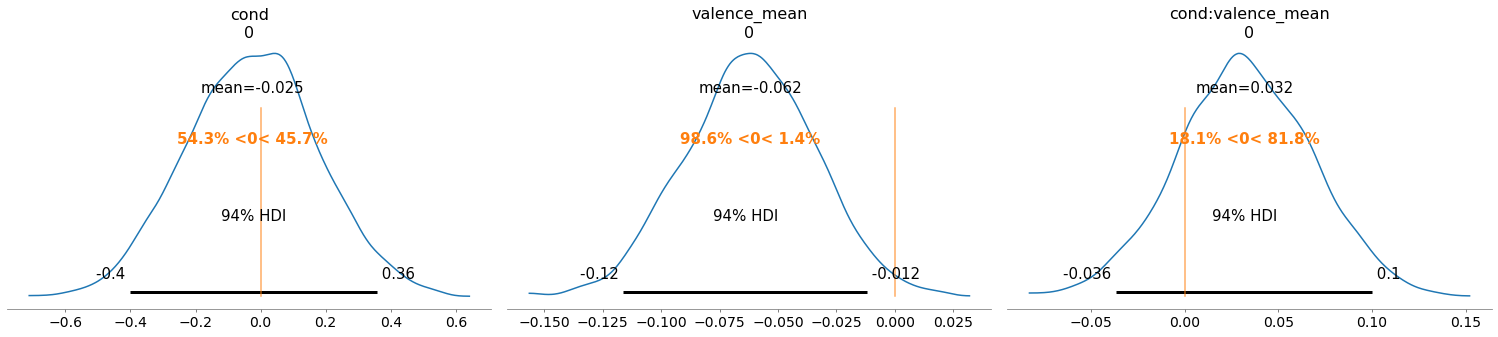

In [30]:
# plot the fixed effect posteriors to examine significance
az.plot_posterior(results, ref_val=0.0, var_names=['cond', 'valence_mean', 'cond:valence_mean']);

## Perform model comparison to determine what parameters to keep

- Not all the parameters of the model help with the fit
- We can perform Bayesian model comparison to identify the simplest model that best captures the data

In [31]:
# next build the regression without the item random effect
res_noitem = model.fit('correct ~ cond * valence_mean', 
                    random=['1|subj'], 
                    family='bernoulli')

/home/per/anaconda3/lib/python3.7/site-packages/bambi/models.py:269: UserWarning: Modeling the probability that correct=='1'
  self.y.name, str(self.clean_data[self.y.name].iloc[event])
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subj_offset, 1|subj_sd, cond:valence_mean, valence_mean, cond, Intercept]
INFO:pymc3:NUTS: [1|subj_offset, 1|subj_sd, cond:valence_mean, valence_mean, cond, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:28<00:00, 210.09draws/s]
The acceptance probability does not match the target. It is 0.8833219873387895, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is small

In [32]:
# next build the regression without the interaction
res_nointer = model.fit('correct ~ cond + valence_mean', 
                    random=['1|subj'], 
                    family='bernoulli')

/home/per/anaconda3/lib/python3.7/site-packages/bambi/models.py:269: UserWarning: Modeling the probability that correct=='1'
  self.y.name, str(self.clean_data[self.y.name].iloc[event])
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subj_offset, 1|subj_sd, valence_mean, cond, Intercept]
INFO:pymc3:NUTS: [1|subj_offset, 1|subj_sd, valence_mean, cond, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:17<00:00, 341.31draws/s]
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.
/home/per/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future

In [33]:
# next build the regression with only valence
res_valence = model.fit('correct ~ valence_mean', 
                    random=['1|subj'], 
                    family='bernoulli')

/home/per/anaconda3/lib/python3.7/site-packages/bambi/models.py:269: UserWarning: Modeling the probability that correct=='1'
  self.y.name, str(self.clean_data[self.y.name].iloc[event])
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subj_offset, 1|subj_sd, valence_mean, Intercept]
INFO:pymc3:NUTS: [1|subj_offset, 1|subj_sd, valence_mean, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:18<00:00, 327.48draws/s]
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.
/home/per/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. No

In [34]:
# next build the regression with only cond
res_cond = model.fit('correct ~ cond', 
                    random=['1|subj'], 
                    family='bernoulli')

/home/per/anaconda3/lib/python3.7/site-packages/bambi/models.py:269: UserWarning: Modeling the probability that correct=='1'
  self.y.name, str(self.clean_data[self.y.name].iloc[event])
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subj_offset, 1|subj_sd, cond, Intercept]
INFO:pymc3:NUTS: [1|subj_offset, 1|subj_sd, cond, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:12<00:00, 496.11draws/s]
The acceptance probability does not match the target. It is 0.8789515664864597, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.
/home/per/anaconda3/lib/python3.7

## Compare the models

- The model with the fewest parameters that is not significantly worse than the other models is the best to keep.

In [38]:
cres = az.compare({'full':results, 'noitem': res_noitem, 
                   'noint':res_nointer, 'cond': res_cond, 'valence': res_valence})
cres

/home/per/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:150: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
full,0,-2763.49,84.2649,0,0.376739,39.5753,0,False,log
noint,1,-2763.82,23.7779,0.326962,0.220602,39.6404,2.28266,False,log
noitem,2,-2764.52,24.8419,1.02658,0.112851,39.6469,2.11862,False,log
valence,3,-2765,22.7862,1.51167,0.167903,39.4989,3.16058,False,log
cond,4,-2765.8,22.8885,2.31406,0.121906,39.6141,3.32662,False,log


<AxesSubplot:xlabel='Log'>

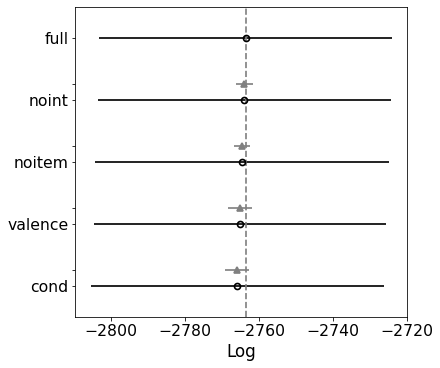

In [39]:
az.plot_compare(cres, insample_dev=False)

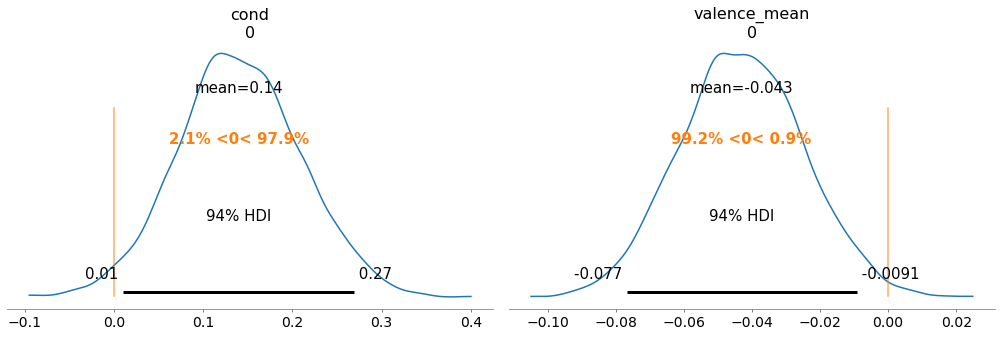

In [41]:
az.plot_posterior(res_nointer, ref_val=0.0, var_names=['cond', 'valence_mean']);

## Conclusion

- There seem to be effects of both condition and valence value on whether or not participants got targets correct.
- Many more analyses to do!!!

# Thanks for a great semester!!!

- We will post the final project template this weekend
- Find us on Slack or at office hours for assistance
- Don't forget to fill out course evals!

### Have a great break!!!